<a href="https://colab.research.google.com/github/AcqmalFadhilla/tfx-cat-dog-classification/blob/master/tfx_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tfx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.4 MB/s eta 0:

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!KAGGLE_DATA_DIR=/content/ kaggle datasets download anthonytherrien/dog-vs-cat

Dataset URL: https://www.kaggle.com/datasets/anthonytherrien/dog-vs-cat
License(s): CC-BY-SA-4.0
 99% 357M/360M [00:14<00:00, 25.9MB/s]
100% 360M/360M [00:14<00:00, 25.9MB/s]


In [ ]:
!unzip /content/dog-vs-cat.zip

Archive:  /content/dog-vs-cat.zip
  inflating: animals/cat/00000-4122619873.png  
  inflating: animals/cat/00001-4122619874.png  
  inflating: animals/cat/00002-4122619875.png  
  inflating: animals/cat/00003-4122619876.png  
  inflating: animals/cat/00004-4122619877.png  
  inflating: animals/cat/00005-4122619878.png  
  inflating: animals/cat/00006-4122619879.png  
  inflating: animals/cat/00007-4122619880.png  
  inflating: animals/cat/00008-4122619881.png  
  inflating: animals/cat/00009-4122619882.png  
  inflating: animals/cat/00010-4122619883.png  
  inflating: animals/cat/00011-4122619884.png  
  inflating: animals/cat/00012-4122619885.png  
  inflating: animals/cat/00013-4122619886.png  
  inflating: animals/cat/00014-4122619887.png  
  inflating: animals/cat/00015-4122619888.png  
  inflating: animals/cat/00016-4122619889.png  
  inflating: animals/cat/00017-4122619890.png  
  inflating: animals/cat/00018-4122619891.png  
  inflating: animals/cat/00019-4122619892.png  
  infl

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tfx.components import ImportExampleGen
from tfx.components import StatisticsGen
from tfx.components import SchemaGen
from tfx.components import ExampleValidator
from tfx.components import Transform
from tfx.components import Tuner
from tfx.components import Trainer
from tfx.components import Evaluator
from tfx.components import Pusher
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import example_gen_pb2

from functools import partial
from tensorflow.train import Example, Features, Feature
from tensorflow.train import BytesList, FloatList, Int64List


# Data

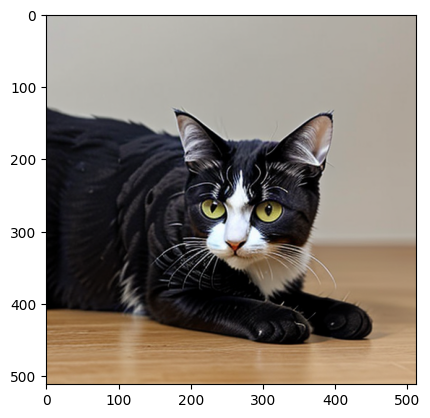

In [ ]:
image = tf.io.read_file('/content/animals/cat/00008-4122619881.png')
image = tf.image.decode_png(image, channels=3)
plt.imshow(image)

### Convert data image to tfrecord

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
DATA_DIR = '/content/animals'

load_split = partial(tf.keras.preprocessing.image_dataset_from_directory,
                     DATA_DIR,
                    #  validation_split=0.2,
                     shuffle=True,
                     color_mode="rgb",
                     image_size=(IMG_WIDTH, IMG_HEIGHT),
                     batch_size=1,
                     seed=123,
                     )

ds_train = load_split()

class_name = ds_train.class_names
print(f"class:{class_name}")

Found 1000 files belonging to 2 classes.
class:['cat', 'dog']


tf.Tensor(0, shape=(), dtype=int32)


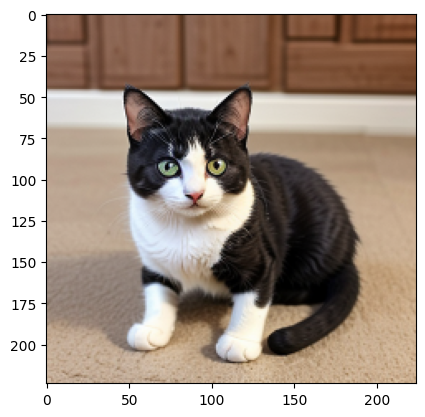

In [ ]:
images, label = next(iter(ds_train))
# add division 255.0 because image dtype changed tf.float
images = images[0] / 255
plt.imshow(images)
print(label[0])

In [ ]:
# image will be wrapped with tf.example
def make_example(encoded_image, label):
  image_feature = Feature(
      bytes_list=BytesList(value=[encoded_image])
  )
  label_feature = Feature(
      int64_list=Int64List(value=[label])
  )

  example = Example(
      features=Features(
          feature={
              "image": image_feature,
              "label": label_feature
          }
      )
  )

  return example.SerializeToString()


def process_image(image, label):
  image = image / 255.0
  # image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  # image = tf.io.encode_png(image)
  image = tf.io.serialize_tensor(image)
  return image, label

ds_encode = ds_train.unbatch().map(process_image)

In [ ]:
!mkdir dataset

In [ ]:
def make_tfrecord(ds_encode, filename, num_shard):
  # shard is used for making to data into small parts
  for shard in range(num_shard):
    ds_shard = ds_encode.shard(num_shard, shard).as_numpy_iterator()

    with tf.io.TFRecordWriter(f"{filename}-shard_{shard}.tfrecord") as writer:
      for image, label in ds_shard:
        example = make_example(image, label)
        writer.write(example)
  print("Done")

make_tfrecord(ds_encode, "dataset/data", 64)

Done


# Data ingestion

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
replace content/dataset/data-shard_55.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/dataset/data-shard_55.tfrecord  
  inflating: content/dataset/data-shard_52.tfrecord  
  inflating: content/dataset/data-shard_57.tfrecord  
  inflating: content/dataset/data-shard_54.tfrecord  
  inflating: content/dataset/data-shard_27.tfrecord  
  inflating: content/dataset/data-shard_7.tfrecord  
  inflating: content/dataset/data-shard_22.tfrecord  
  inflating: content/dataset/data-shard_49.tfrecord  
  inflating: content/dataset/data-shard_36.tfrecord  
  inflating: content/dataset/data-shard_58.tfrecord  
  inflating: content/dataset/data-shard_13.tfrecord  
  inflating: content/dataset/data-shard_61.tfrecord  
  inflating: content/dataset/data-shard_45.tfrecord  
  inflating: content/dataset/data-shard_39.tfrecord  
  inflating: content/dataset/data-shard_38.tfrecord  
  inflating: content/dataset/data-shard_53.tfrecord  
  inflating: content/datase

In [ ]:
import os

DATA_ROOT = "/content/content/dataset"

PIPELINE_NAME = "cat-dog-pipeline"
SCHEMA_PIPELINE_NAME = "cat-dog-tfdv-schema"
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'metadata.db')
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)

In [ ]:
interactive_context= InteractiveContext(pipeline_root=PIPELINE_ROOT)

### Components example gen

In [ ]:
from os.path import split
from tfx.components import ImportExampleGen

# making component example gen
output = example_gen_pb2.Output(
    split_config=example_gen_pb2.SplitConfig(splits=[
        example_gen_pb2.SplitConfig.Split(name="train", hash_buckets=32),
        example_gen_pb2.SplitConfig.Split(name="eval", hash_buckets=8)
    ])
)

In [ ]:
example_gen = ImportExampleGen(input_base=DATA_ROOT, output_config=output)
interactive_context.run(example_gen)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 43
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=ImportExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\211PNG\r\n\032\n\000\000\000\rIHDR\000\000\000\340\000\000\000\340\010\002\000\000\000\225O\375\266\000\000 \000IDATx\234|\375Y\263eYr\036\210\371\260\366\336g>\347\316S\314\221ce\326\210B\025A\002U\rT\267\265(QO\375\252\037#3\231\351Y\317z\220dbKmm\326T[K\224\201j\022l\262A\260T(\024j\036r\210\310\214\341\316\343\031\367\260\226\273\353a\255}\"\n\000u\263*-\362\306\271\347\356\263\267\017\237\177\376\271/\374\337\375\357\377\267\246\212f\210\346\310\020P\274\000B\020\017*\"\241\251\253\320\324\214\210d\314\224\261#\"vL\304\010\000`\200hj\200\000\200\210DDD\014\210`\014h\006f\246\246b`\006h\212HH\204L\214\304*f`\252\242\"\"\336\304\000\321@\000\220\220\001\200\342\253\211\210\020\021\301\214\001\021\3004H\010&^\203\227\320\2104jJDf\000\310DN\220 c\340\234\311\201!\" \232\211\305\313\200x\345\000\200JH\000\010\200\006\240*\246\212\000\252j`\010HDL\3169\"FGL\210\210d\026\177\\\r\014\014\000\321,\276\0

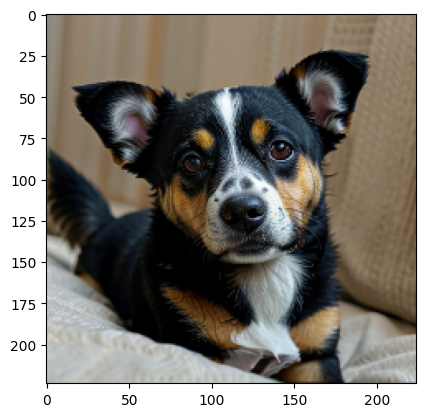

In [ ]:
train_uri = os.path.join(example_gen.outputs["examples"].get()[0].uri, "Split-train")
tfrecord_filenames = [os.path.join(train_uri, name) for name in os.listdir(train_uri)]
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

for raw_record in dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)
  image = example.features.feature["image"].bytes_list.value[0]
  label = example.features.feature["label"].int64_list.value[0]

  image = tf.io.decode_png(image, tf.uint8)
  image = tf.cast(image, tf.float32) / 255.0
  plt.imshow(image)
  if label == 0:
    print(f"cat")
  else:
    print(f"dog")


# Data validation

### Component statistics gen

In [ ]:
# making component statics gen
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples']
)

interactive_context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 44
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [ ]:
interactive_context.show(statistics_gen.outputs['statistics'])

### Component schema gen

In [ ]:
# making component schemagen
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
)

interactive_context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 45
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [ ]:
interactive_context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'image',BYTES,required,,-
'label',INT,required,,-


### component validator

In [ ]:
# making component example validator
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema']
)

interactive_context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 46
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [ ]:
interactive_context.show(example_validator.outputs['anomalies'])

# Data preprocessing

In [ ]:
TRANSFORM_MODULE_FILE = 'cat_dog_transform.py'

In [ ]:
%%writefile {TRANSFORM_MODULE_FILE}
import tensorflow_transform as tft

images = "image"
labels = "label"

def transform_name(key):
  return key + '_xf'

def preprocessing_fn(inputs):
  # tf.io.is_jpeg is used for checking image format
  image = tf.io.is_jpeg(inputs[images])

  # tft.scale_by_min_max is used for normalization value between 0 and 1
  image = tft.scale_by_min_max(image, 0.0, 1.0)

  return {
      transform_name(images): image,
      transform_name(labels): inputs[labels]
  }


Overwriting cat_dog_transform.py


### component Transform

In [ ]:
transform = Transform(
    examples=example_gen.outputs["examples"],
    schema=schema_gen.outputs["schema"],
    module_file=os.path.abspath(TRANSFORM_MODULE_FILE)
)

In [ ]:
interactive_context.run(transform)

Tensor("is_jpeg/Equal:0", shape=(None, 1), dtype=bool)
Tensor("ParseTensor:0", dtype=float32)
Tensor("is_jpeg/Equal:0", shape=(None, 1), dtype=bool)
Tensor("ParseTensor:0", dtype=float32)
Tensor("is_jpeg/Equal:0", shape=(None, 1), dtype=bool)
Tensor("ParseTensor:0", dtype=float32)
Tensor("is_jpeg/Equal:0", shape=(None, 1), dtype=bool)
Tensor("ParseTensor:0", dtype=float32)
Tensor("is_jpeg/Equal:0", shape=(None, 1), dtype=bool)
Tensor("ParseTensor:0", dtype=float32)
Tensor("is_jpeg/Equal:0", shape=(None, 1), dtype=bool)
Tensor("ParseTensor:0", dtype=float32)
Tensor("is_jpeg/Equal:0", shape=(None, 1), dtype=bool)
Tensor("ParseTensor:0", dtype=float32)
Tensor("is_jpeg/Equal:0", shape=(None, 1), dtype=bool)
Tensor("ParseTensor:0", dtype=float32)
Tensor("is_jpeg/Equal:0", shape=(None, 1), dtype=bool)
Tensor("ParseTensor:0", dtype=float32)
Tensor("is_jpeg/Equal:0", shape=(None, 1), dtype=bool)
Tensor("ParseTensor:0", dtype=float32)


ExecutionResult(
    component_id: Transform
    execution_id: 48
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

# Modeling

In [ ]:
TRAIN_MODULE_FILE = 'cat_dog_trainer.py'

In [ ]:
%%writefile {TRAIN_MODULE_FILE}

import tensorflow as tf
import tensorflow_transform as tft
import keras_tuner as kt
from tfx_bsl.tfxio import dataset_options
from tensorflow_transform as tft
from tfx.components.trainer.fn_args_utils import DataAccessor
from tfx.components.trainer.fn_args_utils import FnArgs


IMAGE_KEY = "image"
LABEL_KEY = "label"


# def decode_example(example, transform_name):
  # feature_map = {
      # IMAGE_KEY: tf.io.FixedLenFeature([], tf.string),
      # LABEL_KEY: tf.io.FixedLenFeature([], tf.int64)
  # }
  # parsed = tf.io.parse_single_example(example, feature_map)
  # image = tf.io.parse_tensor(parsed[transform_name(IMAGE_KEY)], out_type=tf.float32)
  # label = parsed[transform_name(LABEL_KEY)]

  # return image, label


def transform_name(key):
  return key + '_xf'


def input_fn(file_pattern, data_accessor, transform_name, batch_size=64) -> tf.data.Dataset:
  dataset = data_accessor.tf_dataset_factory(
    file_pattern,
    dataset_options.TensorFlowDatasetOptions(
        batch_size=batch_size,
        label_key=transform_name(LABEL_KEY)
    ),
    tf_trasform_output.transformed_metadata.schema
  ).repeat()

  return dataset



def build_model() -> tf.keras.Model:
  input = tf.keras.layers.Input(shape=(224, 224, 3), name=transform_name(IMAGE_KEY))
  x = tf.keras.layers.Conv2D(64, 3, padding="same", activation='relu')(input)
  x = tf.keras.layers.MaxPool2D()(x)
  x = tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu')(x)
  x = tf.keras.layers.MaxPool2D()(x)
  x = tf.keras.layers.Conv2D(128, 3, padding="same" activation='relu')(x)
  x = tf.keras.layers.MaxPool2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(input, output)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy()]
  )
  model.summary()

  return model






### component tuner